# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle
import numpy as np
import tensorflow as tf
import time
import os
import cnn_helper
import matplotlib.pyplot as plt
from scipy.misc import imread, imresize

# TODO: fill this in based on where you saved the training and testing data
training_file = 'dataset/train.p'
testing_file =  'dataset/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
   
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']


In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = np.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


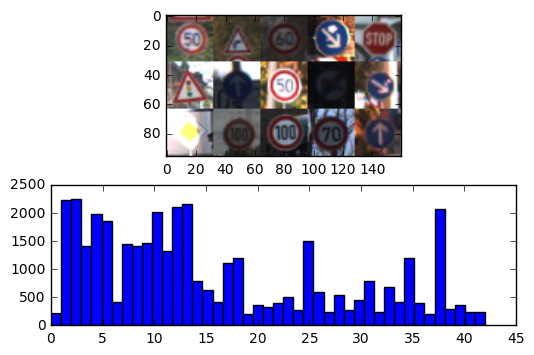

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

img = X_train[np.random.randint(0,n_train,15)]
img_show = np.vstack((np.hstack((img[0],img[1],img[2],img[3],img[4])), 
                      np.hstack((img[5],img[6],img[7],img[8],img[9])),
                      np.hstack((img[10],img[11],img[12],img[13],img[14]))))

fig, axes = plt.subplots(nrows=2,ncols=1)  
axes[0].imshow(img_show)
axes[1].hist(y_train, n_classes)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import preprocessor
#to gray scale
X_train = preprocessor.to_grayscale(X_train)
X_test = preprocessor.to_grayscale(X_test)

#augment the training data using translation and rotation
X_train, y_train = preprocessor.augment_data(X_train, y_train)
n_train = X_train.shape[0]
print("!!!!!Number of augmented training examples =", n_train)

##normalization
X_train= preprocessor.normalize(X_train)
X_test = preprocessor.normalize(X_test)

##one-hot encoding
y_train_one_hot = preprocessor.one_hot_encoding(y_train,n_classes)
y_test_one_hot = preprocessor.one_hot_encoding(y_test,n_classes)

!!!!!Number of augmented training examples = 117627


In [5]:
#function for training the model
def run_training():
  x = tf.placeholder("float", shape=[None, X_train.shape[1], X_train.shape[2], X_train.shape[3]])
  y_ = tf.placeholder("float", shape=[None, n_classes])
  keep_prob = tf.placeholder("float")
  # Build a Graph that computes predictions from the inference model.
  logits = cnn_helper.inference(x,hidden1_units=32, hidden2_units=64, fc_units=1024, keep_prob_ph =keep_prob)

  # Add to the Graph the Ops for loss calculation.
  loss_op= cnn_helper.loss(logits, y_)

  # Add to the Graph the Ops that calculate and apply gradients.
  train_op = cnn_helper.training(loss_op, 1e-4)

  # Add the Op to compare the logits to the labels during evaluation.
  eval_op = cnn_helper.evaluation(logits, y_)

  # Build the summary Tensor based on the TF collection of Summaries.
  summary = tf.merge_all_summaries()

  # Add the variable initializer Op.
  init = tf.global_variables_initializer()

  # Create a saver for writing training checkpoints.
  saver = tf.train.Saver()

  # Create a session for running Ops on the Graph.
  sess = tf.Session()

  # Instantiate a SummaryWriter to output summaries and the Graph.
  summary_writer = tf.train.SummaryWriter("./log", sess.graph)

  # And then after everything is built:

  # Run the Op to initialize the variables.
  sess.run(init)

  batch_size=256
  max_steps =20000
  # Start the training loop.
  for step in range(max_steps):
    start_time = time.time()
    # Fill a feed dictionary with the actual set of images and labels
    # for this particular training step.
    batch = cnn_helper.get_next_batch_train(X_train, y_train_one_hot, batch_size)
    feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5}

    # Run one step of the model.  The return values are the activations
    # from the `train_op` (which is discarded) and the `loss` Op.  To
    # inspect the values of your Ops or variables, you may include them
    # in the list passed to sess.run() and the value tensors will be
    # returned in the tuple from the call.
    _, loss_value = sess.run([train_op, loss_op],feed_dict=feed_dict)

    duration = time.time() - start_time

    # Write the summaries and print an overview fairly often.
    if step % 100 == 0:
      # Print status to stdout.
      print('Step %d: loss = %.2f (%.3f sec)' % (step, loss_value, duration))
      # Update the events file.
      summary_str = sess.run(summary, feed_dict=feed_dict)
      summary_writer.add_summary(summary_str, step)
      summary_writer.flush()

    # Save a checkpoint 
    if (step + 1) % 1000 == 0 or (step + 1) == max_steps:
      checkpoint_file = os.path.join("./log/", 'model.ckpt')
      saver.save(sess, checkpoint_file, global_step=step)
      
    # Evaluate the model periodically.
    if (step + 1) % 2000 == 0 or (step + 1) == max_steps:
      print('Training Data Eval:')
      cnn_helper.do_eval(sess, eval_op, x, y_, keep_prob, X_train[0:39209], y_train_one_hot[0:39209], 1000)
      # Evaluate against the test set.
      print('Test Data Eval:')
      cnn_helper.do_eval(sess, eval_op, x, y_, keep_prob, X_test,  y_test_one_hot, 1000)
  sess.close()

In [ ]:
#actually training the model
if tf.gfile.Exists("./log/"):
    tf.gfile.DeleteRecursively("./log/")
    tf.gfile.MakeDirs("./log/")
start_time = time.time()
run_training()
training_time = time.time() - start_time
print("total time for training: %.2f sec" % training_time)

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My model is a CNN model. There are 4 hidden layers. Note that the 'hidden1' and 'hidden2' are all connected to the 'fully_connect1' layer.The architecture of the model is shown as follows:


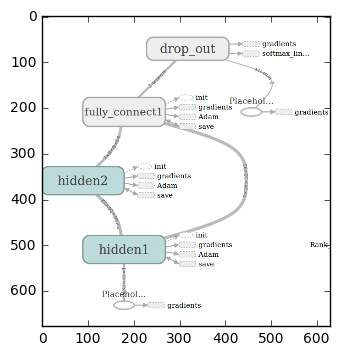

the model structure is defined by the funcition 'inference' in cnn_helper.py, which is as follows:


In [17]:
### Train your model here.
### Feel free to use as many code cells as needed.


print("My model is a CNN model. There are 4 hidden layers. Note that the 'hidden1' and 'hidden2' are all connected to the 'fully_connect1' layer.\
The architecture of the model is shown as follows:")
model = imread("./cnn_architecture.jpg")
plt.imshow(np.uint8(model))
plt.show()

print("the model structure is defined by the funcition 'inference' in cnn_helper.py, which is as follows:")


In [16]:
def inference(images_ph, hidden1_units=32, hidden2_units=64, fc_units=1024, keep_prob_ph=1.0):
  """Build the model up to where it may be used for inference.

  Args:
    images_ph: Images placeholder.
    hidden1_units: Size of the first hidden layer.
    hidden2_units: Size of the second hidden layer.
    fc_units: Size of the fully connected layer.
    keep_prob_ph: drop_out keep probability placeholder

  Returns:
    softmax_linear: Output tensor with the computed logits.
  """
  with tf.name_scope('hidden1'):
    W_conv1 = _weight_variable([5, 5, 1, hidden1_units], 'weights')
    b_conv1 = _bias_variable([hidden1_units], 'biases')  
    h_conv1 = tf.nn.tanh(_conv2d(images_ph, W_conv1) + b_conv1)
    h_pool1 = _max_pool_2x2(h_conv1)
    
  with tf.name_scope('hidden2'):  
    W_conv2 = _weight_variable([5, 5, hidden1_units, hidden2_units], 'weights')
    b_conv2 = _bias_variable([hidden2_units], 'biases')  
    h_conv2 = tf.nn.tanh(_conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = _max_pool_2x2(h_conv2)
  
  
  with tf.name_scope('fully_connect1'):
    W_fc1 = _weight_variable([8 * 8 * hidden2_units+8*8*hidden1_units, fc_units], 'weights')
    b_fc1 = _bias_variable([fc_units], 'biases')  
    h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*hidden2_units])
    h_pool1_pool = _max_pool_2x2(h_pool1)
    h_pool1_pool_flat = tf.reshape(h_pool1_pool, [-1, 8*8*hidden1_units])
    h_combine = tf.concat(1, [h_pool2_flat,h_pool1_pool_flat])
    h_fc1 = tf.nn.tanh(tf.matmul(h_combine, W_fc1) + b_fc1)
  
#    W_fc1 = weight_variable([8 * 8 * hidden2_units, fc_units], 'weights')
#    b_fc1 = bias_variable([fc_units], 'biases')  
#    h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*hidden2_units])
#    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

  with tf.name_scope('drop_out'): 
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob_ph)
  
  with tf.name_scope('softmax_linear'):
    W_fc2 = _weight_variable([fc_units, 43], 'weights')
    b_fc2 = _bias_variable([43], 'biases')  
    logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
 
  return logits

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


### Question 5


_What approach did you take in coming up with a solution to this problem?_

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [14]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
def run_prediction():
  from scipy.misc import imread, imresize    
  imgs = []
  for i in range(5):
    path = './test_images/{0}.jpg'.format(i+1)   
    imgs.append(imread(path))
    
  X = np.empty(shape=[5,32,32,1])
  for i in range(5):      
    img = imresize(imgs[i], (32,32))
    img_gray = preprocessor.to_grayscale(img)
    img_gray_normalized = preprocessor.normalize(img_gray)
    X[i] = img_gray_normalized
  
  x = tf.placeholder("float", [None, 32, 32, 1])
  keep_prob = tf.placeholder("float")
  # Build a Graph that computes predictions from the inference model.
  logits = cnn_helper.inference(x,hidden1_units=32, hidden2_units=64, fc_units=1024, keep_prob_ph =keep_prob)
  probs = tf.nn.softmax(logits)
  top_k_op = tf.nn.top_k(probs, 5)

  saver = tf.train.Saver()
  
  with tf.Session() as sess:
    saver.restore(sess, "./log_model/model.ckpt-19999")
    print("Model restored")
    values, indices = sess.run(top_k_op, feed_dict={x:X, keep_prob:1})
    
  import csv
  reader = csv.reader(open('signnames.csv', newline=''), delimiter=',')
  sign_map = {row[0]: row[1] for row in reader}
 
  for i in range(5):
    plt.figure(i)
    plt.imshow(np.uint8(imgs[i]))
    plt.show()
    probs = values[i]
    signs = indices[i]
    for k in range(probs.shape[0]):
      print("%.4f: %s" % (probs[k], sign_map[str(signs[k])]))

In [ ]:
#actually do prediction on new images
run_prediction()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

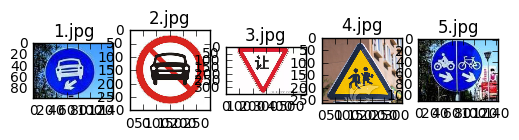

In [12]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
from scipy.misc import imread, imresize    
fig, axes = plt.subplots(nrows=1,ncols=5)  
for i in range(5):
    path = './test_images/{0}.jpg'.format(i+1) 
    img = imread(path)
    axes[i].imshow(img)
    axes[i].set_title('{0}.jpg'.format(i+1))
plt.show()  

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.